# Import libraries

In [1]:
from tqdm import tqdm
from astropy.visualization import simple_norm
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import pickle as pkl
import geopandas as gpd

from umap import UMAP
from umap.parametric_umap import ParametricUMAP
from scipy import stats

import datetime
datecode = '{}-{}-{}'.format(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day)

interim_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/'
processed_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/processed/'
raw_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/raw/'
external_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/external/'

# make new folders in interim and processed directories for today's date

if os.path.join(interim_dir, datecode) not in [x[0] for x in os.walk(interim_dir)]:
    os.mkdir(os.path.join(interim_dir, datecode))
if os.path.join(processed_dir, datecode) not in [x[0] for x in os.walk(processed_dir)]:
    os.mkdir(os.path.join(processed_dir, datecode))

print(datecode)

2022-06-30 12:38:26.865669: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2022-6-30


In [20]:
import pylab
NUM_COLORS = 15

cm = pylab.get_cmap('plasma')
color_list = []
for i in range(NUM_COLORS):
    color = cm(i/NUM_COLORS)  # color will now be an RGBA tuple
    color_list.append(color)

# Import data

In [2]:
QLD_EM = pd.read_csv('/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/processed/QLD_AusEM_interp.csv')

# Window parameter selection
# we want resolution to be ~1/20 or 1/30 of window width
# x interval in dataset is 10 m

window_resolution_m = 20 # x dimension sample interval in m
window_size_m = 500 # window x dimension in m
overlap_wid_m = 200 # ~half window size - must be divisible by window_resolution

# convert m to sample counts
window_size = int(window_size_m / window_resolution_m)
overlap_wid = int(overlap_wid_m / window_resolution_m)

QLD_EM = QLD_EM.iloc[::int(window_resolution_m/20)]

## Definitions, normalisation

In [3]:
# 0-1 normalisation per timegate

EMZ_HPRG_list = ['EMZ_HPRG' + '[{}]'.format(i) for i in range(1,16)]
EMZ_HPRG_norm_list = [i + '_norm' for i in EMZ_HPRG_list]
EMZ_HPRG_lognorm_list = [i + '_lognorm' for i in EMZ_HPRG_list]

# 0-1 normalisation per timegate

for timegate in range(len(EMZ_HPRG_list)):
    min = QLD_EM[EMZ_HPRG_list[timegate]].min()
    max = QLD_EM[EMZ_HPRG_list[timegate]].max()
    QLD_EM[EMZ_HPRG_norm_list[timegate]] = (QLD_EM[EMZ_HPRG_list[timegate]] - min) / (max - min)
    QLD_EM[EMZ_HPRG_lognorm_list[timegate]] = np.log10(QLD_EM[EMZ_HPRG_norm_list[timegate]] + 0.00001)
    logmin = QLD_EM[EMZ_HPRG_lognorm_list[timegate]].min()
    logmax = QLD_EM[EMZ_HPRG_lognorm_list[timegate]].max()    
    QLD_EM[EMZ_HPRG_lognorm_list[timegate]] = ((QLD_EM[EMZ_HPRG_lognorm_list[timegate]] - min) / (max - min)) + 1

## Open windowed data

In [46]:
file_datecode = '2022-6-29' 

with open(interim_dir + '{}/filenames_all_normdata_{}m-window.pickle'.format(file_datecode, window_size_m), 'rb') as handle1:
    stack = pkl.load(handle1)

with open(interim_dir + '{}/all_x_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'rb') as handle2:
    x_stack = pkl.load(handle2)

with open(interim_dir + '{}/all_line_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'rb') as handle3:
    line_stack = pkl.load(handle3)

with open(interim_dir + '{}/all_easting_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'rb') as handle4:
    E_stack = pkl.load(handle4)

with open(interim_dir + '{}/all_northing_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'rb') as handle5:
    N_stack = pkl.load(handle5)

with open(interim_dir + '{}/filenames_all_normdata_{}m-window.pickle'.format(file_datecode, window_size_m), 'rb') as handle6:
    filenames = pkl.load(handle6)

linex_list = []

for i in range(len(line_stack)):
    linex = str(line_stack[i]) + '_x' + str(x_stack[i,0])
    linex_list.append(linex)

linex_ar = np.array(linex_list)

with open(interim_dir + '{}/QLD_AusEM_CNN-features_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'rb') as handle:
    data = pkl.load(handle)

print(x_stack.shape, data.shape)

(153370, 25) (153370, 512)


In [53]:
linex_ar

array(['2001001_x20', '2001001_x220', '2001001_x420', ...,
       '91917901_x9020', '91917901_x9220', '91917901_x9420'], dtype='<U16')

# UMAP

In [7]:
# # UMAP

data_norm = stats.zscore(data, axis = 1)

umap_obj = ParametricUMAP(n_neighbors=25, min_dist=0.0, n_components=3, metric='euclidean', random_state=69, verbose=True)
embedding = umap_obj.fit_transform(data_norm[::2])
embedding = umap_obj.transform(data_norm)

with open(interim_dir + '{}/lognorm_CNN-embeddings_{}m-window_stack.pickle'.format(datecode, window_size_m), 'wb') as handle:
    pkl.dump(embedding, handle, protocol=4)

/home/taschaap/miniconda3/envs/fastai_test/lib/python3.7/site-packages/umap/parametric_umap.py:150: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  tensorflow installation. Setting global_correlation_loss_weight to zero."


ParametricUMAP(optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f45d520d250>)
Thu Jun 30 10:07:04 2022 Construct fuzzy simplicial set
Thu Jun 30 10:07:04 2022 Finding Nearest Neighbors
Thu Jun 30 10:07:04 2022 Building RP forest with 19 trees
Thu Jun 30 10:07:05 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Thu Jun 30 10:07:31 2022 Finished Nearest Neighbor Search
Thu Jun 30 10:07:35 2022 Construct embedding


2022-06-30 10:09:23.338012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-30 10:09:23.516730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-06-30 10:09:23.516773: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-30 10:09:23.570120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimi

Epoch 1/10
12714/12714 [==============================] - 184s 14ms/step - loss: 0.0613
Epoch 2/10
12714/12714 [==============================] - 179s 14ms/step - loss: 0.0588
Epoch 3/10
12714/12714 [==============================] - 169s 13ms/step - loss: 0.0584
Epoch 4/10
12714/12714 [==============================] - 162s 13ms/step - loss: 0.0582
Epoch 5/10
12714/12714 [==============================] - 167s 13ms/step - loss: 0.0583
Epoch 6/10
12714/12714 [==============================] - 183s 14ms/step - loss: 0.0584
Epoch 7/10
12714/12714 [==============================] - 185s 15ms/step - loss: 0.0579
Epoch 8/10
12714/12714 [==============================] - 187s 15ms/step - loss: 0.0578
Epoch 9/10
12714/12714 [==============================] - 182s 14ms/step - loss: 0.0577
Epoch 10/10
2397/2397 [==============================] - 6s 2ms/step
Thu Jun 30 10:40:20 2022 Finished embedding
154/154 [==============================] - 1s 5ms/step


In [26]:
# 3D UMAP - RGB transformation

rgbembeds = embedding.copy()
for i in range(3):
    min = rgbembeds[:,i].min()
    max = rgbembeds[:,i].max()
    rgbembeds[:,i] = (rgbembeds[:,i] - min) / (max - min)

from matplotlib.colors import to_hex
rgb_colormap = [to_hex(i) for i in rgbembeds]


## UMAP plot

In [ ]:
fig = go.Figure()

with open(interim_dir + '{}/lognorm_CNN-embeddings_{}m-window_stack.pickle'.format(datecode, window_size_m), 'rb') as handle:
    embedding = pkl.load(handle)

ass_marker = dict(size=1, color=rgb_colormap, opacity=0.5, line=dict(width=0))
fig.add_trace(go.Scatter3d( x=embedding[:,0], y=embedding[:,1], z=embedding[:,2],
                                   text = linex_list,
                                   name = 'All tiles',
                                   mode='markers',
                                   hovertemplate='<br>'.join(['Line: %{text}',
                                                              'UMAP 0: %{x}',
                                                              'UMAP 1: %{y}',
                                                              'UMAP 2: %{z}']),
                                   marker = ass_marker))

fig.update_layout(scene = dict(xaxis_title='UMAP 0',
               yaxis_title='UMAP 1',
               zaxis_title='UMAP 2'),
               title="QLD AusEM {} m tiles".format(window_size_m),
               width = 1000,
               height = 800,
               margin=dict(l=10, r=10, b=25, t=50)
               )
fig.write_html('/mnt/c/Projects/Blogs/AusAEM_blog_TS/outputs/{}m_tile_3DUMAP.html'.format(window_size_m))
fig.show()     

## Spatial plot

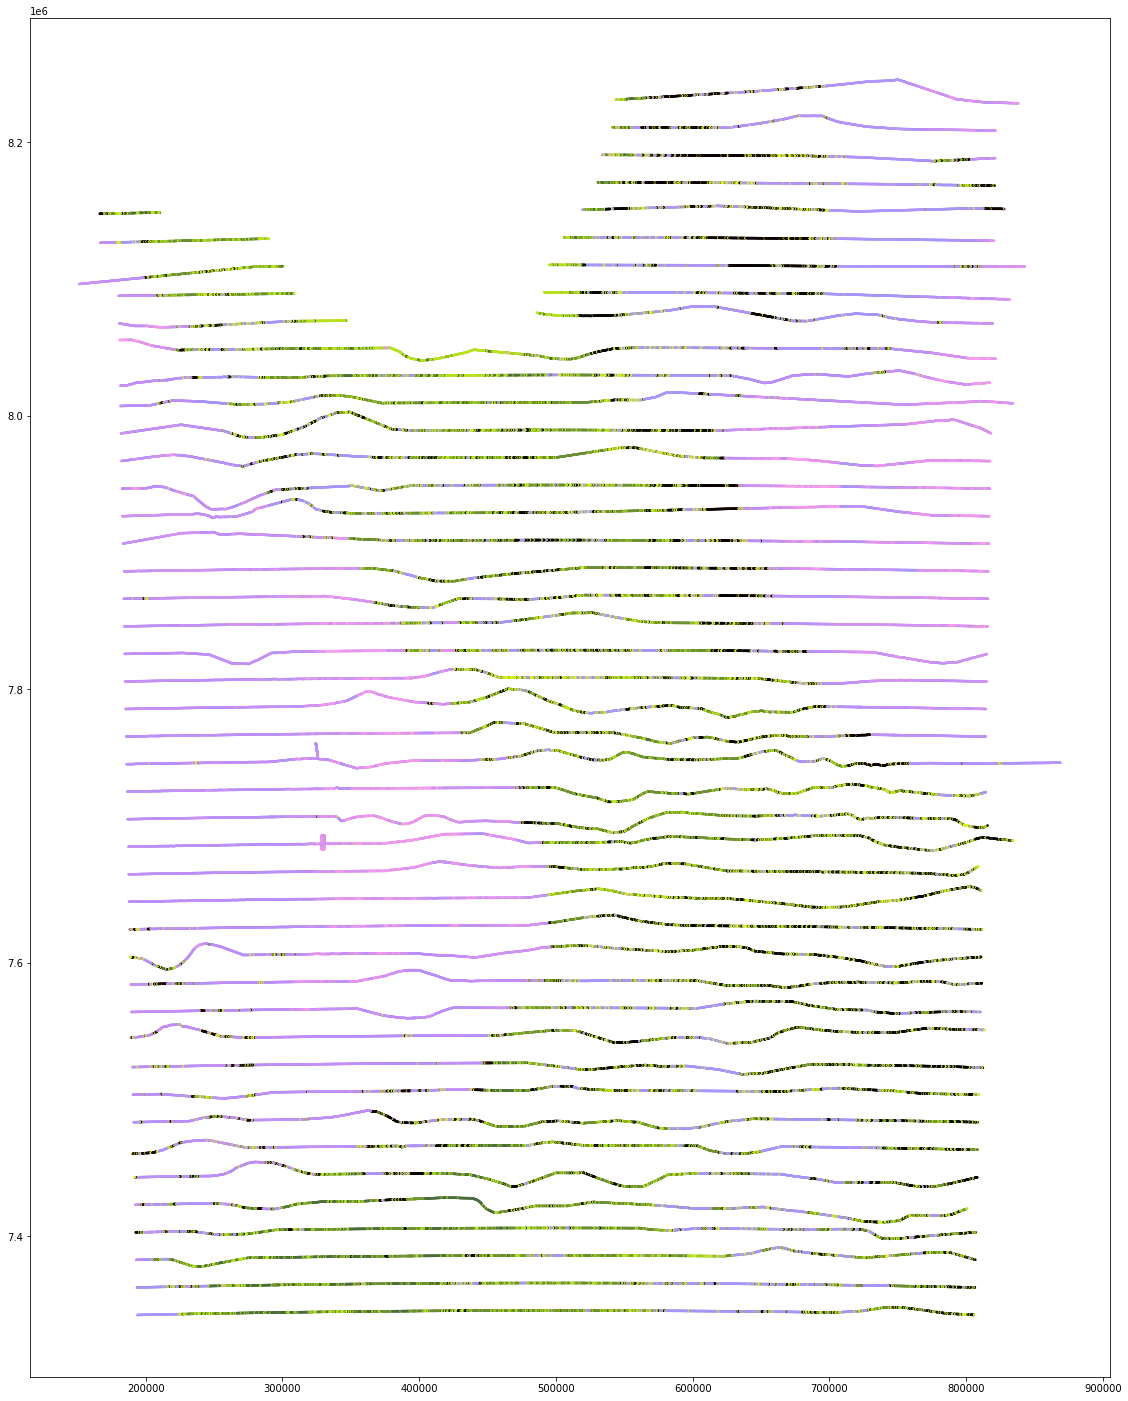

In [11]:
fig, ax = plt.subplots(figsize = (25,25))
ax.scatter(np.mean(E_stack, axis = 1), np.mean(N_stack, axis = 1), c = [to_hex(i) for i in rgbembeds], s=2, alpha=1) 
ax.set(aspect = 1)
plt.show()

# Tile inspection

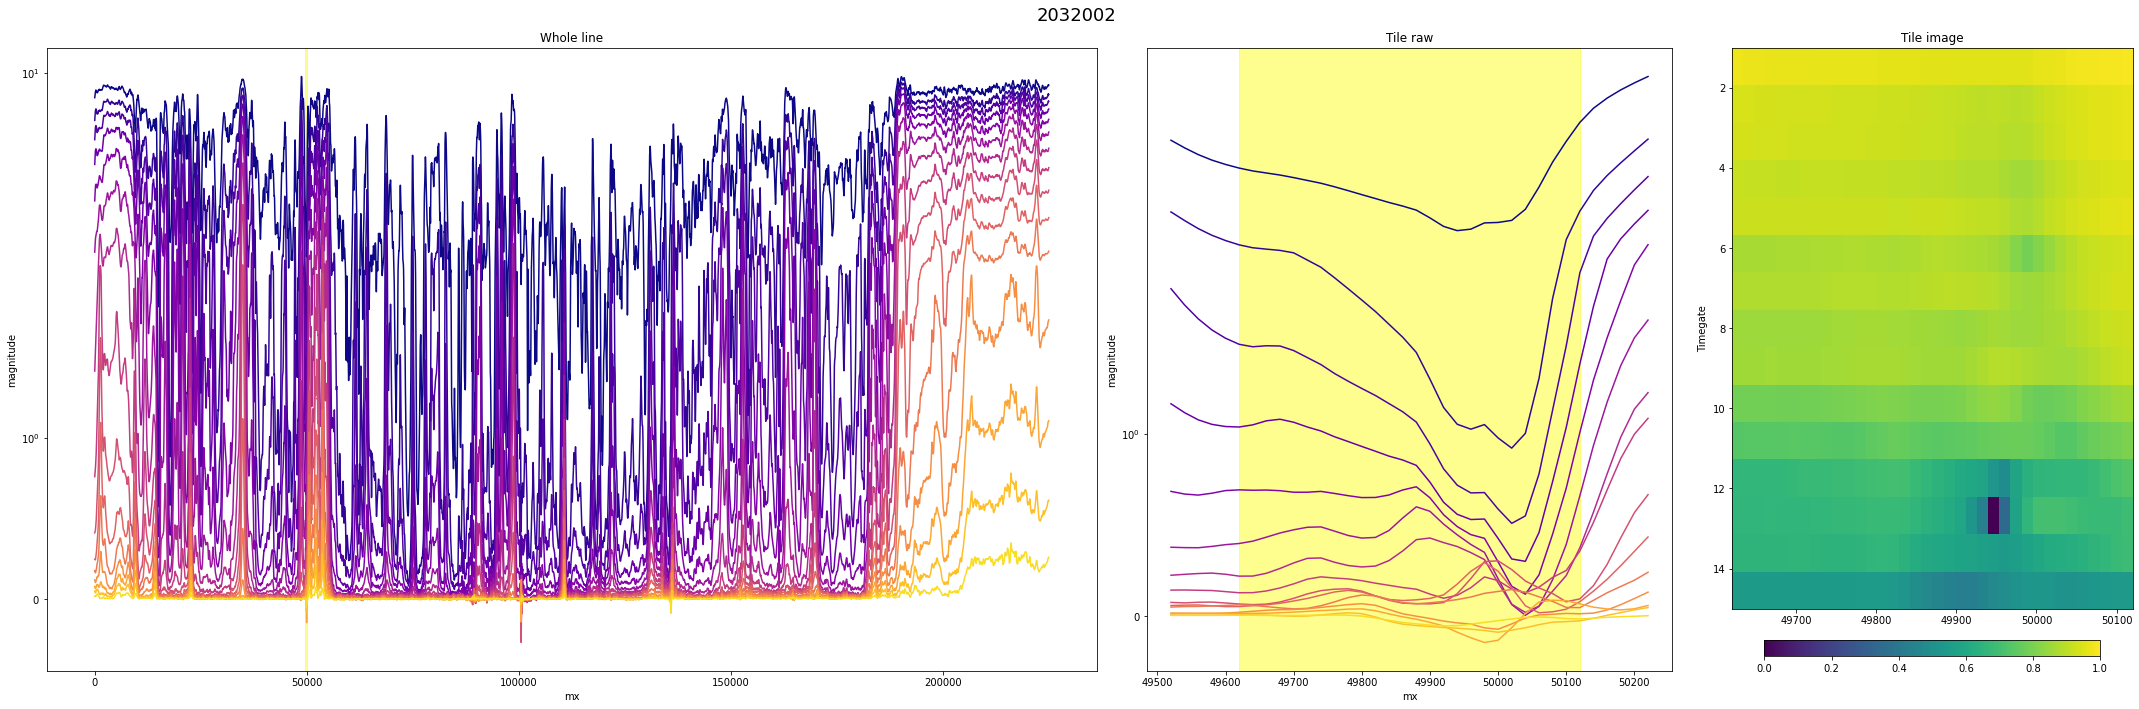

In [212]:
# Paste line/x string here
linex_val = '2032002_x-15916'
# emin = (np.abs(E_stack[line_stack == line] - 340615.19)).argmin()
line, xmin = linex_val.split('_x')
line = int(line)
linedata = QLD_EM[(QLD_EM.Line == line)]
xmin = int(xmin)
xmin = linedata[linedata.x.astype('int16') == xmin]['x'].values[0]
xmax = xmin + 500
tiledata = linedata[(linedata.x >= xmin-100) & (linedata.x <=xmax+100)]


# colour vspan by hex color

hexcolor = np.array(rgb_colormap)[linex_ar == linex_val][0]

fig, ax = plt.subplots(1,3, figsize = (30,10), gridspec_kw={'width_ratios': [2, 1, 0.8]})

i = 0
for timegate in EMZ_HPRG_list:
    ax[0].plot(linedata.x, linedata[timegate], color = color_list[i])
    ax[1].plot(tiledata.x, tiledata[timegate], color = color_list[i])
    i += 1
im = ax[2].imshow(tiledata[EMZ_HPRG_lognorm_list].T, aspect = 50, vmin = 0, vmax = 1, extent = (xmin, xmax, 15, 1))

# Add vspan to show tile location
ax[0].axvspan(xmin, xmax, alpha = 0.5, color = hexcolor)
ax[1].axvspan(xmin, xmax, alpha = 0.5, color = hexcolor)

ax[0].set(title = 'Whole line', xlabel = 'mx', ylabel = 'magnitude', yscale = 'symlog')
ax[1].set(title = 'Tile raw', xlabel = 'mx', ylabel = 'magnitude', yscale = 'symlog')
ax[2].set(title = 'Tile image', ylabel = 'Timegate')

fig.colorbar(im, shrink = 0.8, orientation = 'horizontal', pad = 0.05, fraction = 0.05)
fig.suptitle('Line ' + str(line), fontsize = 18)
plt.tight_layout()
# plt.savefig('/mnt/c/Projects/RIO/WINU_AEM/reporting/Meeting06/{}.png'.format(linex_val), dpi = 300, bbox_inches='tight') 
plt.show()

In [266]:

fig, ax = plt.subplots(figsize = (25,25))
ax.scatter(np.mean(E_stack, axis = 1), np.mean(N_stack, axis = 1), c = [to_hex(i) for i in rgbembeds], s=2, alpha=1) 
for timegate in range(1,16):
    negdata = QLD_EM[QLD_EM['EMZ_HPRG[{}]_lognorm'.format(timegate)] < np.percentile(QLD_EM['EMZ_HPRG[{}]_lognorm'.format(timegate)], 0.005)]
    ax.scatter(negdata.E, negdata.N, s = 100, color = color_list[timegate-1], label = 'EMZ_HPRG[{}]_lognorm'.format(timegate), alpha = 0.7) 
ax.set(aspect = 1)
ax.legend()
fig.suptitle('Lowest 0.5pct response for each timegate', fontsize = 24, y = 0.9)
plt.show()

In [262]:
color_list[timegate]

IndexError: list index out of range

# UMAP output to spatial

In [12]:
df = pd.DataFrame()
df['E'] = np.mean(E_stack, axis = 1)
df['N'] = np.mean(N_stack, axis = 1)
df['UMAP_color'] = [to_hex(i) for i in rgbembeds]
df['linex'] = linex_list
df.to_csv(processed_dir + '{}/{}_{}_map.csv'.format(datecode, datecode, window_size_m), index = False)

# Euclidean distance to Mt Isa

100%|██████████| 153370/153370 [00:02<00:00, 73911.53it/s]


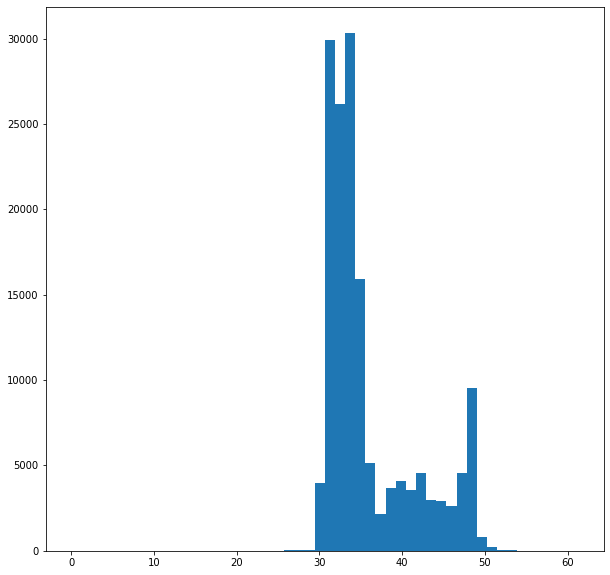

In [177]:
from scipy.spatial import distance
MtIsa = data[linex_ar == '2032002_x-15916']
Isa_distances = []
for tile in tqdm(data):
    Isa_distances.append(distance.euclidean(MtIsa, tile))
Isa_distances_ar = np.array(Isa_distances)

fig, ax = plt.subplots(figsize = (10,10))
ax.hist(Isa_distances_ar, bins = 50)
plt.show()

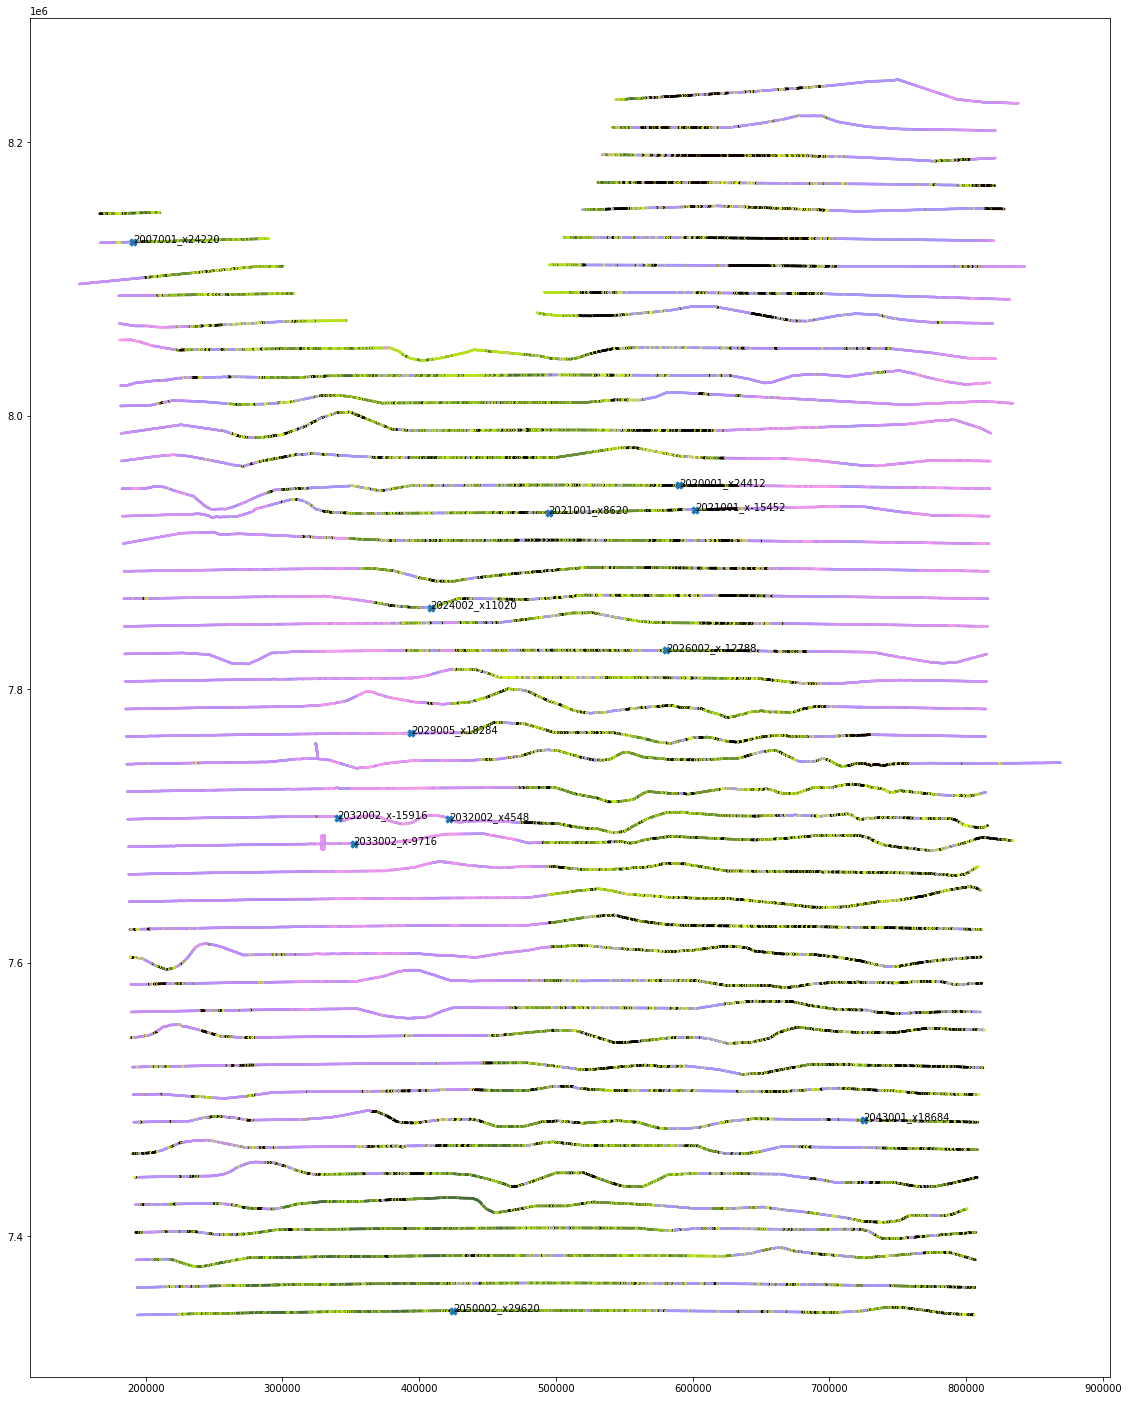

In [190]:
fig, ax = plt.subplots(figsize = (25,25))
ax.scatter(np.mean(E_stack, axis = 1), np.mean(N_stack, axis = 1), c = [to_hex(i) for i in rgbembeds], s=2, alpha=1) 
ax.scatter(np.mean(E_stack, axis = 1)[Isa_distances_ar<25], np.mean(N_stack, axis = 1)[Isa_distances_ar<25], marker = 'X', s=50, alpha=1) 
for i in range(len(linex_ar[Isa_distances_ar<25])):
    ax.text(np.mean(E_stack, axis = 1)[Isa_distances_ar<25][i], np.mean(N_stack, axis = 1)[Isa_distances_ar<25][i], linex_ar[Isa_distances_ar<25][i]) 
ax.set(aspect = 1)
plt.show()

# Mask basin features

<AxesSubplot:>

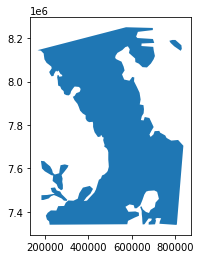

In [5]:
df = pd.read_csv(processed_dir + '{}/{}_{}_map.csv'.format(datecode, datecode, window_size_m))
basin_poly_fn = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/external/Basin_outline.gpkg'

basin_poly = gpd.read_file(basin_poly_fn)
basin_poly.plot()

<AxesSubplot:>

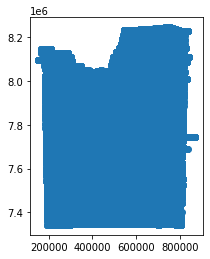

In [6]:
# Select tiles outside basin outline

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.E, df.N), crs = 'EPSG:28354')

gdf.plot()


<AxesSubplot:>

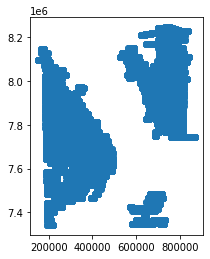

In [7]:
gdf[gdf.within(basin_poly.geometry.unary_union) == False].plot()


In [203]:
data_subset = data[gdf.within(basin_poly.geometry.unary_union) == False]
E_subset = E_stack[gdf.within(basin_poly.geometry.unary_union) == False]
N_subset = N_stack[gdf.within(basin_poly.geometry.unary_union) == False]
linex_subset = np.array(linex_list)[gdf.within(basin_poly.geometry.unary_union) == False]

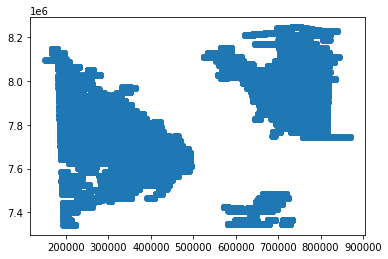

In [10]:
plt.scatter(np.mean(E_subset, axis = 1), np.mean(N_subset, axis = 1))

# UMAP on basement subset

In [11]:
# # UMAP

data_subset_norm = stats.zscore(data_subset, axis = 1)

umap_obj = ParametricUMAP(n_neighbors=25, min_dist=0.0, n_components=3, metric='euclidean', random_state=69, verbose=True)
embedding_subset = umap_obj.fit_transform(data_subset_norm[::2])
embedding_subset = umap_obj.transform(data_subset_norm)

with open(interim_dir + '{}/basement_subset_lognorm_CNN-embeddings_{}m-window_stack.pickle'.format(datecode, window_size_m), 'wb') as handle:
    pkl.dump(embedding_subset, handle, protocol=4)

/home/taschaap/miniconda3/envs/fastai_test/lib/python3.7/site-packages/umap/parametric_umap.py:150: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  tensorflow installation. Setting global_correlation_loss_weight to zero."


ParametricUMAP(optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbbc1232f50>)
Thu Jun 30 12:41:17 2022 Construct fuzzy simplicial set
Thu Jun 30 12:41:17 2022 Finding Nearest Neighbors
Thu Jun 30 12:41:17 2022 Building RP forest with 15 trees
Thu Jun 30 12:41:17 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Thu Jun 30 12:41:42 2022 Finished Nearest Neighbor Search
Thu Jun 30 12:41:45 2022 Construct embedding


2022-06-30 12:42:36.530452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-30 12:42:36.704261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-06-30 12:42:36.704340: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-30 12:42:36.745464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimi

Epoch 1/10
6992/6992 [==============================] - 105s 14ms/step - loss: 0.0892
Epoch 2/10
6992/6992 [==============================] - 92s 13ms/step - loss: 0.0854
Epoch 3/10
6992/6992 [==============================] - 91s 13ms/step - loss: 0.0849
Epoch 4/10
6992/6992 [==============================] - 95s 14ms/step - loss: 0.0846
Epoch 5/10
6992/6992 [==============================] - 91s 13ms/step - loss: 0.0840
Epoch 6/10
6992/6992 [==============================] - 89s 13ms/step - loss: 0.0836
Epoch 7/10
6992/6992 [==============================] - 91s 13ms/step - loss: 0.0834
Epoch 8/10
6992/6992 [==============================] - 92s 13ms/step - loss: 0.0830
Epoch 9/10
6992/6992 [==============================] - 90s 13ms/step - loss: 0.0827
Epoch 10/10
1212/1212 [==============================] - 2s 1ms/step
Thu Jun 30 12:58:15 2022 Finished embedding
78/78 [==============================] - 0s 4ms/step


In [13]:
# 3D UMAP - RGB transformation

rgbembeds_subset = embedding_subset.copy()
for i in range(3):
    min = rgbembeds_subset[:,i].min()
    max = rgbembeds_subset[:,i].max()
    rgbembeds_subset[:,i] = (rgbembeds_subset[:,i] - min) / (max - min)

from matplotlib.colors import to_hex
subset_colormap = [to_hex(i) for i in rgbembeds_subset]


In [ ]:
fig = go.Figure()

ass_marker = dict(size=1, color=subset_colormap, opacity=0.5, line=dict(width=0))
fig.add_trace(go.Scatter3d( x=embedding_subset[:, 0], y=embedding_subset[:, 1], z=embedding_subset[:, 2],
                                   text = np.array(linex_list)[gdf.within(basin_poly.geometry.unary_union) == False],
                                   name = 'All tiles',
                                   mode='markers',
                                   hovertemplate='<br>'.join(['Line: %{text}',
                                                              'UMAP 0: %{x}',
                                                              'UMAP 1: %{y}',
                                                              'UMAP 2: %{z}']),
                                   marker = ass_marker))

fig.update_layout(scene = dict(xaxis_title='UMAP 0',
               yaxis_title='UMAP 1',
               zaxis_title='UMAP 2'),
               title="QLD basement AusEM {} m tiles".format(window_size_m),
               width = 1000,
               height = 800,
               margin=dict(l=10, r=10, b=25, t=50)
               )
# fig.write_html('/mnt/c/Projects/RIO/WINU_AEM/reporting/Meeting06/PatersonAEM_500mtiles_3D-UMAP.html')
fig.show()     

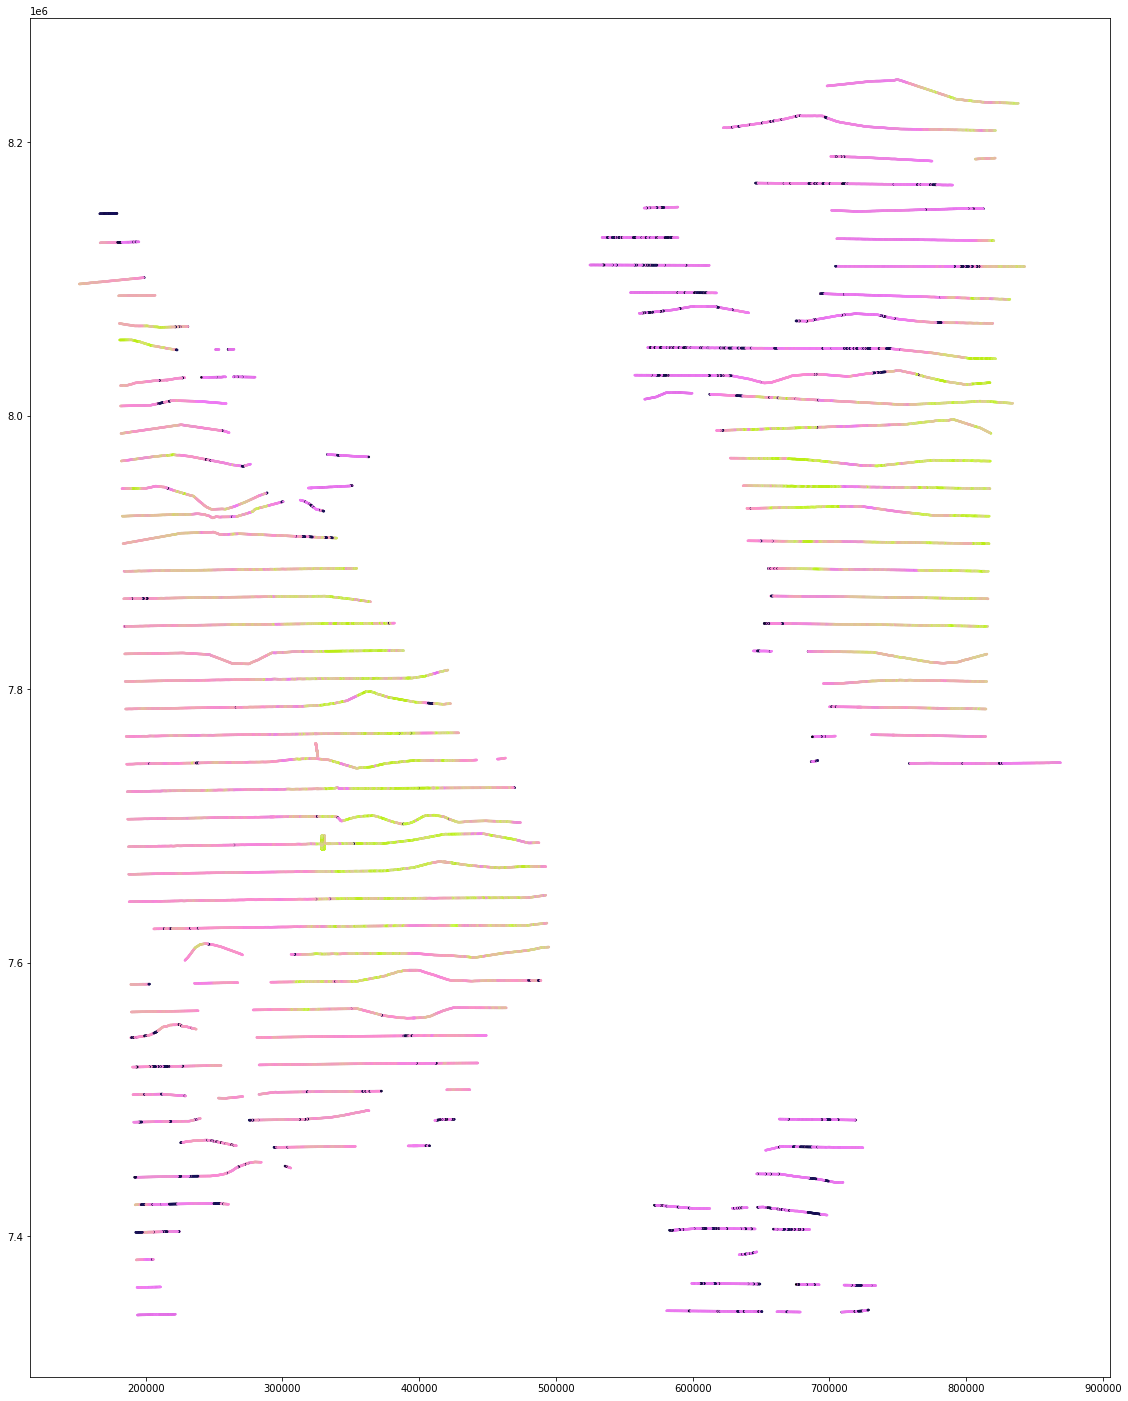

In [17]:
fig, ax = plt.subplots(figsize = (25,25))
ax.scatter(np.mean(E_subset, axis = 1), np.mean(N_subset, axis = 1), c = subset_colormap, s=2, alpha=1) 
ax.set(aspect = 1)
plt.show()

# Subset UMAP output to spatial

In [18]:
df_subset = pd.DataFrame()
df_subset['E'] = np.mean(E_subset, axis = 1)
df_subset['N'] = np.mean(N_subset, axis = 1)
df_subset['UMAP_color'] = subset_colormap
df_subset['linex'] = np.array(linex_list)[gdf.within(basin_poly.geometry.unary_union) == False]
df_subset.to_csv(processed_dir + '{}/{}_{}_subset_map.csv'.format(datecode, datecode, window_size_m), index = False)